# Mental Health and Psychological Distress
**study on medical student mental health: burnout, empathy, anxiety, and depression**

This workbook is to analyze how different factors might be related psychological distress. Study is based on data on medical students' mental health in Switzerland: demographic information, self-reported health status, psychological tests results, and survey responses.

Workbook contains:
- [EDA](#eda)
- [Data Preparation](#prepare-data)
- [Data Modeling](#data-modeling)
- [Evaluate the Results / Summary](#summary)

Data can be downloaded from Kaggle: https://www.kaggle.com/datasets/thedevastator/medical-student-mental-health.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv(r'data\Data_MedTeach.csv', header=0)
df.head()

,id,age,year,sex,glang,part,job,stud_h,health,psyt,jspe,qcae_cog,qcae_aff,amsp,erec_mean,cesd,stai_t,mbi_ex,mbi_cy,mbi_ea
0,2,18,1,1,120,1,0,56,3,0,88,62,27,17,0.738095,34,61,17,13,20
1,4,26,4,1,1,1,0,20,4,0,109,55,37,22,0.690476,7,33,14,11,26
2,9,21,3,2,1,0,0,36,3,0,106,64,39,17,0.690476,25,73,24,7,23
3,10,21,2,2,1,0,1,51,5,0,101,52,33,18,0.833333,17,48,16,10,21
4,13,21,3,1,1,1,0,22,4,0,102,58,28,21,0.690476,14,46,22,14,23


## EDA<a id='eda'></a>

Dataset has the follwing columns:

* id: Participant's ID.
* age: Age of the participant
* year: Year of study of the participant
* sex: Gender of the participant. Q: To which gender do you identify the most ? 1=Man; 2=Woman; 3=Non-binary
* glang: Language spoken by the participant.
* part: Partnership status. Q: Do you have a partner?; 0=No; 1=Yes
* job: Job of the participant. Q: Do you have a paid job?; 0=No; 1=Yes
* stud_h: Hours of study per week of the participant. Q: How many hours per week do you study on top of courses?
* health: Self-reported health status of the participant. Q:  How satisfied are you with your health?; 1=Verydissatisfied to 5=Verysatisfied
* psyt: Psychological distress score of the participant. Q: During the last 12 months have you ever consulted a psychotherapist or a psychiatrist for your health?;0=No; 1=Yes
* jspe: Job satisfaction score of the participant. (Integer)
* qcae_cog: Cognitive empathy score of the participant. (Integer)
* qcae_aff: Affective empathy score of the participant. (Integer)
* amsp: Academic motivation score of the participant. (Integer)
* erec_mean: Empathy rating score mean of the participant. (Integer)
* cesd: Center for Epidemiologic Studies Depression scale of the participant. (Integer)
* stai_t: State-Trait Anxiety Inventory scale of the participant. (Integer)
* mbi_ex: Maslach Burnout Inventory-Exhaustion scale of the participant. (Integer)
* mbi_cy: Maslach Burnout Inventory - Cynicism Scale of the participant. (Integer)
* mbi_ea: Maslach Burnout Inventory - Professional Efficacy Scale of the participant. (Integer)

In [6]:
df.describe()

,id,age,year,sex,glang,part,job,stud_h,health,psyt,jspe,qcae_cog,qcae_aff,amsp,erec_mean,cesd,stai_t,mbi_ex,mbi_cy,mbi_ea
count,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000,886.000000
mean,889.709932,22.383747,3.102709,1.695260,14.327314,0.563205,0.348758,25.288939,3.777652,0.224605,106.374718,58.525959,34.784424,23.150113,0.720144,18.050790,42.898420,16.878104,10.079007,24.207675
std,515.555875,3.300664,1.763937,0.472665,32.366389,0.496269,0.476847,15.927875,1.061497,0.417558,8.784012,6.570341,5.377062,4.993220,0.093570,11.478731,11.978458,5.256025,4.592609,4.633675
min,2.000000,17.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,67.000000,37.000000,18.000000,6.000000,0.357143,0.000000,20.000000,5.000000,4.000000,10.000000
25%,447.500000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.000000,3.000000,0.000000,101.000000,54.000000,31.000000,20.000000,0.666667,9.000000,34.000000,13.000000,6.000000,21.000000
50%,876.000000,22.000000,3.000000,2.000000,1.000000,1.000000,0.000000,25.000000,4.000000,0.000000,107.000000,58.000000,35.000000,23.000000,0.726190,16.000000,43.000000,17.000000,9.000000,24.000000
75%,1341.750000,24.000000,5.000000,2.000000,1.000000,1.000000,1.000000,36.000000,5.000000,0.000000,113.000000,63.000000,39.000000,26.750000,0.785714,25.000000,51.000000,20.000000,13.000000,28.000000
max,1790.000000,49.000000,6.000000,3.000000,121.000000,1.000000,1.000000,70.000000,5.000000,1.000000,125.000000,76.000000,48.000000,35.000000,0.952381,56.000000,77.000000,30.000000,24.000000,36.000000


In [7]:
df.dtypes

id             int64
age            int64
year           int64
sex            int64
glang          int64
part           int64
job            int64
stud_h         int64
health         int64
psyt           int64
jspe           int64
qcae_cog       int64
qcae_aff       int64
amsp           int64
erec_mean    float64
cesd           int64
stai_t         int64
mbi_ex         int64
mbi_cy         int64
mbi_ea         int64
dtype: object

In [12]:
df.shape

(886, 20)

C:\Temp\ipykernel_11604\2961459546.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax);


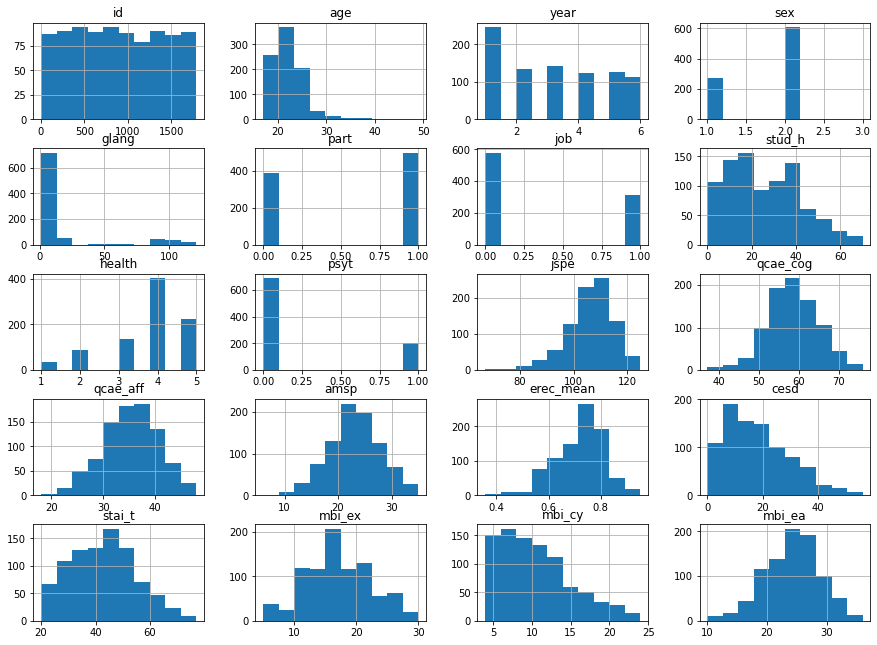

In [16]:
fig = plt.figure(figsize = (15, 11))
ax = fig.gca()
df.hist(ax = ax);

## Data Preparation<a id='prepare-data'></a>

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         886 non-null    int64  
 1   age        886 non-null    int64  
 2   year       886 non-null    int64  
 3   sex        886 non-null    int64  
 4   glang      886 non-null    int64  
 5   part       886 non-null    int64  
 6   job        886 non-null    int64  
 7   stud_h     886 non-null    int64  
 8   health     886 non-null    int64  
 9   psyt       886 non-null    int64  
 10  jspe       886 non-null    int64  
 11  qcae_cog   886 non-null    int64  
 12  qcae_aff   886 non-null    int64  
 13  amsp       886 non-null    int64  
 14  erec_mean  886 non-null    float64
 15  cesd       886 non-null    int64  
 16  stai_t     886 non-null    int64  
 17  mbi_ex     886 non-null    int64  
 18  mbi_cy     886 non-null    int64  
 19  mbi_ea     886 non-null    int64  
dtypes: float64

In [17]:
# check if there are any missing values

df.columns[df.isnull().mean() !=0]

Index([], dtype='object')

In [21]:
df['psyt'].value_counts()

0    687
1    199
Name: psyt, dtype: int64